In [ ]:
#You have to download all the images in the same repertory where is record this code !!

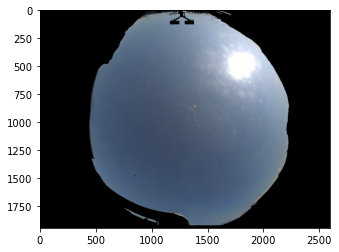

<ipython-input-7-5e97ca599fc6>:32: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  Test_gray = color.rgb2gray(Test)


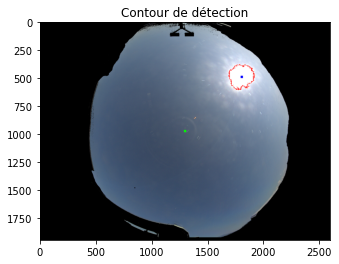

364.0932936527777
62.71159574023437
-14.54595443148215 1276.293307615757


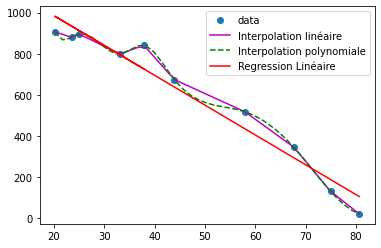

In [7]:
#This part of the code determine the sun center starting from the S and I coefficient determine in the linear regression
#in the bottom of this code.

import imageio
import matplotlib.pyplot as plt
from skimage import color, io, filters
from scipy import ndimage
import numpy as np
from PIL import Image
from scipy.interpolate import interp1d

f = imageio.imread('cam2 UTC 19-07-05_15-59-59-37.jpg')
g = imageio.imread('cam2 UTC 19-07-07_17-59-59-50.jpg')

f_gray=color.rgb2gray(f)
hauteur,largeur=f_gray.shape
slope,intercept=0.09907717016267961,-6.666339309727121
S,I=-14.54595443148215,1276.293307615757

def Mask(Test2):
    Mask = imageio.imread('masque.png')
    Mask = Mask[:,:,0]
    
    Masque=np.copy(Test2)
    
    for i in range(3):
        b = Masque[:,:,i]
        b[Mask==0] = 0
        Masque[:,:,i] = b
    return Masque

def Sobel_Detection(Test):
    Test_gray = color.rgb2gray(Test)
    edge_sobel = filters.sobel(Test_gray)
#    plt.imshow(edge_sobel, cmap=plt.cm.gray)
#    plt.title("Sobel Edge Detection")
#    plt.show()
    return edge_sobel


def Roberts_Detection(Test):
    Test_gray = color.rgb2gray(Test)
    edge_roberts = filters.roberts(Test_gray)
#    plt.imshow(edge_roberts, cmap=plt.cm.gray)
#    plt.title("Roberts Edge Detection")
#    plt.show()
    return edge_roberts

def PreDetection_soleil(f):
    f_gray=color.rgb2gray(f)
    sun=np.copy(f_gray)
    for i in range(hauteur):
        for j in range(largeur):
            if (sun[i,j]<=0.9999):
                sun[i,j]=0
            else:
                sun[i,j]=1
#    plt.imshow(sun, cmap='gray')
#    plt.title("Pré détection du soleil (sun)")
#    plt.show()
    return sun

def Detection_soleil(f):
    sun=PreDetection_soleil(f)
    edge_sun_sobel=Sobel_Detection(sun)
    
    resultat=np.copy(f)
    c=Detection_centreImage(f)
    s=Detection_centreSoleil(f)
    for i in range (largeur):
        for j in range(hauteur):
            if (edge_sun_sobel[j,i]!=0):
                resultat[j,i]=[255,0,0]
            elif (np.absolute(j-c[0])<=10) and (np.absolute(i-c[1])<=10):
                resultat[j,i]=[0,255,0]
            elif (np.absolute(j -s[0])<=10) and (np.absolute(i-s[1])<=10):
                resultat[j,i]=[0,0,255]
            else:
                resultat[j,i]=f[j,i]
    plt.imshow(resultat)
    plt.title("Contour de détection")
    plt.show()
    return sun

def Detection_centreImage(f):
    return [hauteur//2,largeur//2]

def Detection_centreSoleil(f):
    mask=Mask(f)
    sun=PreDetection_soleil(mask)
    a,r,D,l,h,d,n=0,0,0,0,0,0,0
    for i in range(largeur):
        for j in range (hauteur):
            if (sun[j,i]!=0):
                if a==0: d=j
                if n==0: n=1
                a+=1
        if (a>r):
            r=a
            h=d+a//2
        a=0
    for i in range(largeur):
        if (sun[h,i]!=0):
                if a==0: D=i
                a+=1
    l=D+a//2
    if n!=0:
        return [h,l]
    else:
        return [0,l//2]

#First sketch of the sun angle function which doesn't work.
#def Angle_Soleil(f):
#    fo=1.6
#    ro=1335.886
#    s=Detection_centreSoleil(f)
#    c=Detection_centreImage(f)
#    x=np.absolute(c[0]-s[0])
#    y=np.absolute(c[1]-s[1])
#    r=np.sqrt(x**2+y**2)/ro
#    alpha=2*np.arcsin(r/fo)
#    return alpha

def Nuance(f):
    res=np.copy(f)
    for i in range(largeur):
        for j in range (hauteur):
            res[j][i]=np.sqrt((f[j][i][0]**2+f[j][i][1]**2+f[j][i][2]**2)/3)
    plt.imshow(res)
    plt.show()

def predict(x):
   return slope * x + intercept

def Angle_Soleil2(f):
    s=Detection_centreSoleil(f)
    c=Detection_centreImage(f)
    x=np.absolute(c[0]-s[0])
    y=np.absolute(c[1]-s[1])
    r=np.sqrt(x**2+y**2)
    return predict(r)

def calcul_irradiance(f):
    alpha=Angle_Soleil2(f)
    return S*alpha+I

def classification(f):
    res=np.copy(f)
    for i in range(largeur):
        for j in range (hauteur):
            if (f[j][i][2]+f[j][i][0]!=0):
#                print((f[j][i][0],f[j][i][2]),np.absolute(f[j][i][0]-f[j][i][2])//(f[j][i][0]+f[j][i][2])*255)
#                print((f[j][i][0],f[j][i][2]),np.absolute(f[j][i][0]-f[j][i][2]))
                res[j][i]=np.absolute(f[j][i][0]-f[j][i][2])//(f[j][i][0]+f[j][i][2])*255
    plt.imshow(res)
    plt.show()
    

mask=Mask(f)
m=Mask(f)
plt.imshow(mask)
plt.show()
Detection_soleil(mask)
print(calcul_irradiance(mask))
print(Angle_Soleil2(f))

#This part allows to make a correlation between the solar angle that we have mesured and the irradiance mesured by 
#the solar sensor on the rpooftop at GreEn'Er. 
#The linear regression is using 10 images that we can see below.

# =============================================================================
# DEtermination des fonctions liants angle(rayon) et irradiance(angle)
# =============================================================================

M=np.zeros([10,2])
for k in range(10):
    z=0
    if k==0 : A,z,i=Mask(io.imread('cam2 UTC 19-07-01_04-59-59-31.jpg')),85,19.31
    if k==1 : A,z,i=Mask(io.imread('cam2 UTC 19-07-01_05-59-59-29.jpg')),75.52,129.4
    if k==2 : A,z,i=Mask(io.imread('cam2 UTC 19-07-01_06-59-59-27.jpg')),65.3,345.2
    if k==3 : A,z,i=Mask(io.imread('cam2 UTC 19-07-01_07-59-59-35.jpg')),54.8,517.4
    if k==4 : A,z,i=Mask(io.imread('cam2 UTC 19-07-01_08-59-59-39.jpg')),44.36,673.8
    if k==5 : A,z,i=Mask(io.imread('cam2 UTC 19-07-01_09-59-59-38.jpg')),34.56,798.1
    if k==6 : A,z,i=Mask(io.imread('cam2 UTC 19-07-01_10-59-59-40.jpg')),26.54,879
    if k==7 : A,z,i=Mask(io.imread('cam2 UTC 19-07-01_11-59-59-46.jpg')),22.47,907
    if k==8 : A,z,i=Mask(io.imread('cam2 UTC 19-07-01_12-59-59-46.jpg')),24.48,897
    if k==9 : A,z,i=Mask(io.imread('cam2 UTC 19-07-01_13-59-59-30.jpg')),31.41,841
    m=Mask(A)
    c=Detection_centreImage(A)
    s=Detection_centreSoleil(A)
    x=np.absolute(c[0]-s[0])
    y=np.absolute(c[1]-s[1])
    r=np.sqrt(x**2+y**2)
    r=Angle_Soleil2(m)
    M[k,:]=[i,r]   #mettre z pour angle ou i pour irradiance

from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(M[:,1],M[:,0])

print(slope,intercept)

f = interp1d(M[:,1],M[:,0])
f2 = interp1d(M[:,1],M[:,0], kind='cubic')
xnew = np.linspace(min(M[:,1]), max(M[:,1]), num=41, endpoint=True)

plt.plot(M[:,1],M[:,0], 'o', xnew, f(xnew), 'm-', xnew, f2(xnew), 'g--')
fitLine = predict(M[:,1])
plt.plot(M[:,1], fitLine,'r-',label='Regres Lin')
plt.legend(['data', 'Interpolation linéaire', 'Interpolation polynomiale','Regression Linéaire'], loc='best')

plt.show()


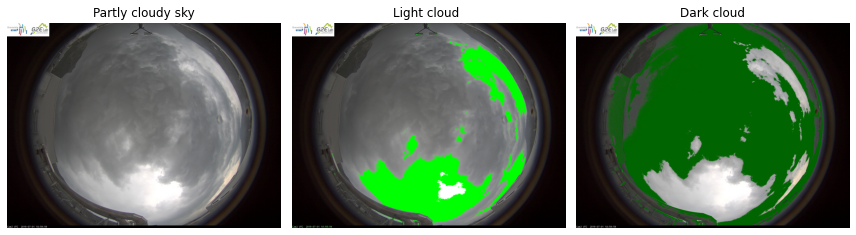

In [10]:
#First cloud detection method with grey values corresponding to dark and light cloud 
import imageio
import matplotlib.pyplot as plt
from skimage import color, io
from scipy import ndimage


#Lecture de l'image et transposition de rgb2gray
Test1 = imageio.imread('cam2 UTC 19-07-08_15-59-59-47.jpg')
Test1_gray = color.rgb2gray(Test1)

Test2 = imageio.imread('cam2 UTC 19-07-01_18-59-59-43.jpg')
Test2_gray = color.rgb2gray(Test2)

Test3 = imageio.imread('cam2 UTC 19-07-03_15-59-59-45.jpg')
Test3_gray = color.rgb2gray(Test3)

# Nuage clair compris entre 0.7 et 0.99 en nuance de gris
resultat=np.copy(Test2_gray)
nuage_clair = np.copy(Test2)

for i in range (largeur):
    for j in range(hauteur):
        if (j>140) or (i>400):
            if (resultat[j,i]<=0.999):
                if (resultat[j,i]>=0.60):
                    nuage_clair[j,i]=[0,255,0]

# Nuage foncé compris entre 0.5 et 0.7 en nuance de gris
nuage_foncé = np.copy(Test2)
resultat=np.copy(Test2_gray)

for i in range (largeur):
    for j in range(hauteur):
        if (j>140) or (i>400):
            if (resultat[j,i]<=0.60):
                if (resultat[j,i]>=0.30):
                    nuage_foncé[j,i]=[0,100,0]

#Affichage des 3 images sur une même ligne
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True,
                         figsize=(12, 6))

axes[0].imshow(Test2)
axes[0].set_title('Partly cloudy sky')

axes[1].imshow(nuage_clair, cmap=plt.cm.gray)
axes[1].set_title('Light cloud ')

axes[2].imshow(nuage_foncé, cmap=plt.cm.gray)
axes[2].set_title('Dark cloud')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

#It doesn't work when the sky is not 100% cloudy.

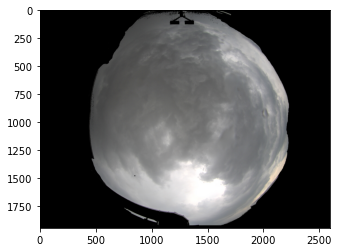

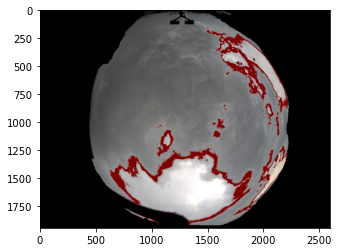

In [12]:
#Second cloud detection method : contour detection
import imageio
import matplotlib.pyplot as plt
from skimage import color, io, filters
from scipy import ndimage
import numpy as np
from PIL import Image
from scipy.interpolate import interp1d

k=1
if (k==0): f = imageio.imread('cam2 UTC 19-07-08_15-59-59-47.jpg')
if (k==1): f = imageio.imread('cam2 UTC 19-07-01_18-59-59-43.jpg')
if (k==2): f = imageio.imread('cam2 UTC 19-07-03_15-59-59-45.jpg')

f_gray=color.rgb2gray(f)
hauteur,largeur=f_gray.shape

def Mask(Test2):
    Mask = imageio.imread('masque.png')
    Mask = Mask[:,:,0]
    
    Masque=np.copy(Test2)
    
    for i in range(3):
        b = Masque[:,:,i]
        b[Mask==0] = 0
        a=sum((Mask!=0).sum(0))
        Masque[:,:,i] = b
    return [Masque,a]

def Sobel_Detection(Test):
    Test_gray = color.rgb2gray(Test)
    edge_sobel = filters.sobel(Test_gray)
#    plt.imshow(edge_sobel, cmap=plt.cm.gray)
#    plt.title("Sobel Edge Detection")
#    plt.show()
    return edge_sobel

def Contrast_nuage(f):
    n=0
    for i in range(hauteur):
        for j in range(largeur):
            a=np.mean(f[i,j])
            if (a>=int(0.6*256)) and (a<=int(0.65*255)):
                f[i,j]=[255,0,0]
                n+=1
            else:
                f[i,j]=[0,0,0]
    return [f,n]

def Detection_nuage(f):
    res=np.copy(f)
    s=Sobel_Detection(Contrast_nuage(f)[0])
    for i in range(hauteur):
        for j in range(largeur):
            if (s[i,j]!=0):
                res[i,j]=[125,0,0]
    return res

def couverture_nuage(f):
    a=Mask(f)[1]
    b=Contrast_nuage(m)[1]
    return b/a

[m,a]=Mask(f)
plt.imshow(m)
plt.show()
plt.imshow(Detection_nuage(m))
plt.show()
#print(couverture_nuage(m))


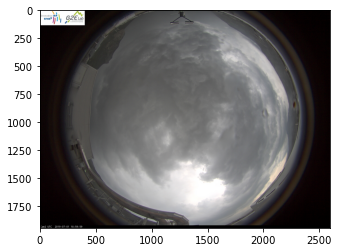

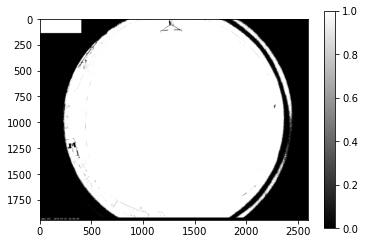

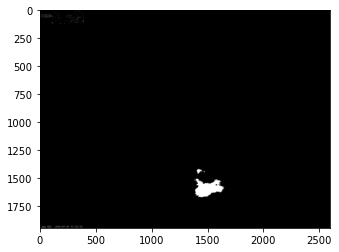

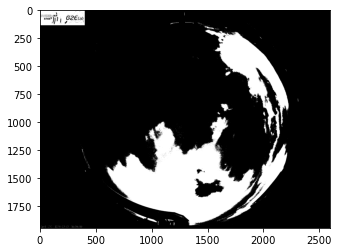

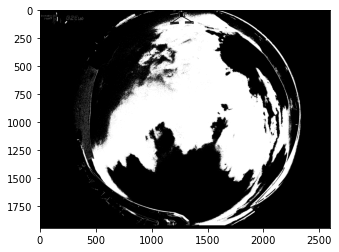

2592 1944


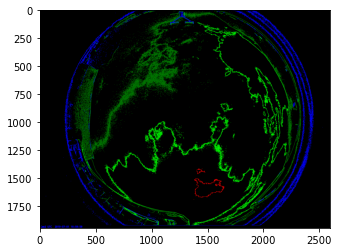

In [14]:
#An other example of the Second cloud detection method : contour detection
#This script is more complete than the other one because it's include the sun detection. But it's also doesn't work 
#when the sky is partially cloudy.  

import numpy as np
import imageio
from skimage import filters
Nuages = imageio.imread('cam2 UTC 19-07-01_18-59-59-43.jpg')

import matplotlib.pyplot as plt
plt.imshow(Nuages)
plt.show()

from skimage import color, io
from scipy import ndimage

Nuages_gray = color.rgb2gray(Nuages)
plt.imshow(Nuages_gray, cmap=plt.cm.gray)
plt.colorbar()

hauteur,largeur=Nuages_gray.shape

eye=np.copy(Nuages_gray)
for i in range(hauteur):
    for j in range(largeur):
        if (eye[i,j]<=0.15):
            eye[i,j]=0
        else:
            eye[i,j]=1

sun=np.copy(Nuages_gray)
for i in range(hauteur):
    for j in range(largeur):
        if (sun[i,j]<=0.9999):
            sun[i,j]=0
        else :
            sun[i,j]=1
            
sun_inv=np.copy(Nuages_gray)
for i in range(hauteur):
    for j in range(largeur):
        if (sun_inv[i,j]<=0.9999):
            sun_inv[i,j]=1
        else :
            sun_inv[i,j]=0
            
clear_clouds=np.copy(Nuages_gray)
for i in range(hauteur):
    for j in range(largeur):
        if (clear_clouds[i,j]<=0.55):
            clear_clouds[i,j]=0
        elif (sun_inv[i,j]==0) :
            clear_clouds[i,j]=0
        else:
            clear_clouds[i,j]=1
                
dark_clouds=np.copy(Nuages_gray)
for i in range(hauteur):
    for j in range(largeur):
        if (dark_clouds[i,j]<=0.35):
            dark_clouds[i,j]=0
        elif (clear_clouds[i,j]==1):
            dark_clouds[i,j]=0
        elif (sun_inv[i,j]==0) :
            dark_clouds[i,j]=0
        else:
            dark_clouds[i,j]=1

plt.imshow(eye, cmap='gray')
plt.show()

plt.imshow(sun, cmap='gray')
plt.show()

plt.imshow(clear_clouds, cmap='gray')
plt.show()

plt.imshow(dark_clouds, cmap='gray')
plt.show()


edge_eye_sobel = filters.sobel(eye)
edge_sun_sobel = filters.sobel(sun)
edge_clear_clouds_sobel = filters.sobel(clear_clouds)
edge_dark_clouds_sobel = filters.sobel(dark_clouds)

resultat=np.copy(Nuages)
for i in range (largeur):
    for j in range(hauteur):
        if (j>140) or (i>400):
            if (edge_eye_sobel[j,i]!=0):
                resultat[j,i]=[0,0,255]
            elif (edge_sun_sobel[j,i]!=0):
                resultat[j,i]=[255,0,0]
            elif (edge_clear_clouds_sobel[j,i]!=0):
                resultat[j,i]=[0,255,0]
            elif (edge_dark_clouds_sobel[j,i]!=0):
                resultat[j,i]=[0,125,0]
            else:
                #resultat[j,i]=Test2[i,j]
                resultat[j,i]=[0,0,0]
        else:
            resultat[j,i]=[0,0,0]

plt.imshow(resultat)
print(largeur, hauteur)
plt.show()

<ipython-input-16-e1c79ab19775>:17: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  f_gray=color.rgb2gray(f)


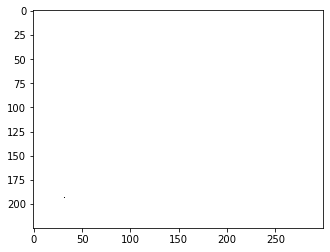

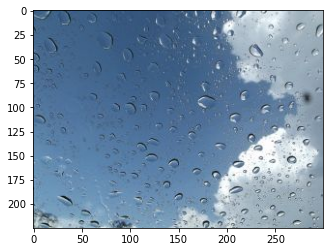

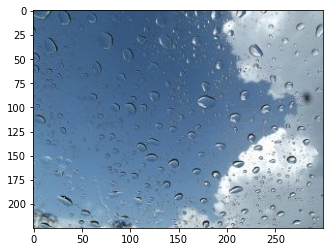

In [16]:
#Raindrops correction:
import imageio
import matplotlib.pyplot as plt
from skimage import color, io, filters
from scipy import ndimage
import numpy as np
from PIL import Image
from scipy.interpolate import interp1d

#f = imageio.imread('Data/cam2 UTC 19-07-05_15-59-59-37.jpg')

k=2
if (k==1): f = imageio.imread('gouttes1.jpg')
if (k==2): f = imageio.imread('gouttes2.png')


f_gray=color.rgb2gray(f)
hauteur,largeur=f_gray.shape

def Mask(Test2):
  
    Mask = imageio.imread('masque.png')
    Mask = Mask[:,:,0]
    
    Masque=np.copy(Test2)
    
    for i in range(3):
        b = Masque[:,:,i]
        b[Mask==0] = 0
        Masque[:,:,i] = b
    return Masque


def Detection_goutte(f):
    res=np.copy(f_gray)
    for i in range(hauteur):
        for j in range(largeur):
            if (np.average(f[i,j])/255<0.3): res[i,j]=0
            else: res[i,j]=1
    return res
    
def Correction_pluie(f):
    r=Detection_goutte(f)
    for i in range(hauteur):
        for j in range(1,largeur-1):
            if r[i,j]==0: #and (j+50<largeur-1): 
#                a,c,d,n=f[i,j-50],1,2,1
##                while ((c!=0) or (d!=0)) and (j+n<largeur-1):
##                    if (r[i,j+n]!=0): c=0
##                    if (c==0) and (r[i,j+n]==0): d=1
##                    if (d==1) and (r[i,j+n]!=0): d=0
##                    n+=1
#                while ((r[i,j+n]==0) and (j+n+50<largeur-1)):
##                    f[i,j+n]=a
#                    n+=1
##                print(j+n+5)
#                b,v=f[i,j+n+50],[]
#                for m in range(3):
#                    v.append((a[m]+b[m])//2)
##                    v.append(np.linspace(a[m],b[m],n))
#                for m in range(n):
#                    f[i,j+m]=v
##                    f[i,j+m]=[int(v[0][m]),int(v[1][m]),int(v[2][m])]
#                j=j+n+50-1
                k,n=f[i,j-5],1
                f[i,j]=k
                while ((r[i,j+n]==0) and (j+n<largeur-1)):
                    f[i,j+n]=k
                    n+=1
#                print(j+n)
                j=j+n
                
    return f 

#m=Mask(f)
plt.imshow(Detection_goutte(f), cmap='gray')
plt.show()
plt.imshow(f)
plt.show()
plt.imshow(Correction_pluie(f))
plt.show()